In [27]:
from awrams.utils.processing.extract import extract
from awrams.utils.gis import ShapefileDB,extent_from_record
from awrams.utils.extents import get_default_extent
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
### Set the customer folder and shapefile name
shp_name = 'NRM_clusters'

In [3]:
## Data Request dir folder path
DataRequest_dir = '/g/data/er4/rs2140/data/'

In [4]:
## Read shape file
shp = DataRequest_dir + 'shapefiles/NRM_clusters/' + shp_name + '.shp'
sdb = ShapefileDB(shp)
sdf = sdb.get_records_df()
sdf

,OBJECTID,Shape_Area,Shape_Leng,code,label
0,1,28.309947,43.872364,CS,Central Slopes
1,2,34.176299,56.117544,EC,East Coast
2,4,45.299310,45.869349,MB,Murray Basin
3,5,124.655757,119.284033,MN,Monsoonal North
4,6,407.116072,137.457553,R,Rangelands
5,7,23.431035,59.887218,SS,Southern Slopes
6,8,50.647491,87.137068,SSWF,Southern and South-Western Flatlands
7,9,19.503388,45.896712,WT,Wet Tropics


In [5]:
emap = pickle.load(open(DataRequest_dir + 'shapefiles/NRM_clusters/' + shp_name + '.pkl', 'rb'))

In [6]:
emap

{'Central Slopes': origin: -24.9,146.3, shape: (182, 125), cell_size: 0.05,
 'East Coast': origin: -21.25,146.55, shape: (279, 144), cell_size: 0.05,
 'Murray Basin': origin: -32.2,138.55, shape: (119, 229), cell_size: 0.05,
 'Monsoonal North': origin: -10.85,119.05, shape: (273, 593), cell_size: 0.05,
 'Rangelands': origin: -16.95,112.85, shape: (329, 723), cell_size: 0.05,
 'Southern Slopes': origin: -34.2,140.95, shape: (193, 203), cell_size: 0.05,
 'Southern and South-Western Flatlands': origin: -26.8,113.5, shape: (194, 518), cell_size: 0.05,
 'Wet Tropics': origin: -10.0,141.35, shape: (245, 177), cell_size: 0.05}

In [22]:
which_cluster = 'Wet Tropics'

In [23]:
cluster = {}
for key in emap:
    if which_cluster in key:
        cluster[key] = emap[key]

In [8]:
period = pd.date_range('1 jan 1976', '31 dec 2005', freq='D')
period

DatetimeIndex(['1976-01-01', '1976-01-02', '1976-01-03', '1976-01-04',
               '1976-01-05', '1976-01-06', '1976-01-07', '1976-01-08',
               '1976-01-09', '1976-01-10',
               ...
               '2005-12-22', '2005-12-23', '2005-12-24', '2005-12-25',
               '2005-12-26', '2005-12-27', '2005-12-28', '2005-12-29',
               '2005-12-30', '2005-12-31'],
              dtype='datetime64[ns]', length=10958, freq='D')

In [9]:
var_names = ['rain_day']  # 'pr', 'tasmax', 'tasmin', 'sm_pct', 'ss_pct', 's0_pct', 'sd_pct', 'qtot', 'rain_day']

input_path_rain = '/g/data/er4/data/CLIMATE/rain_day/'

ddf = {}

for v in var_names:
    print('working on', v)
    
    if v == 'rain_day':
        input_path = input_path_rain 
    elif v in ('temp_max_day', 'tasmax', 'tasmin', 'rsds', 'sfcWind'):     #tasmax
        input_path = input_path_rain
    elif v in ('qtot', 'e0', 'etot', 's0', 'ss', 'sd', 'dd'):
        input_path = input_path_awral
    elif v in ('sm', 's0_pct', 'ss_pct', 'sm_pct', 'sd_pct'):
        input_path = input_path_sm
    elif v in ('ma_wet', 'pen_pet', 'fao_pet', 'asce_pet', 'msl_wet'):
        input_path = input_path_et

    if v == 'sm':
        pattern = input_path + 'sm_[0-9][0-9][0-9][0-9].nc'
    else:
        pattern = input_path + '%s*.nc' % v
    print('input file path:', pattern)
    
    ddf[v] = extract(input_path, pattern, v, cluster, period)

working on rain_day
input file path: /g/data/er4/data/CLIMATE/rain_day/rain_day*.nc


In [10]:
# Aggregating as monthly data
df = ddf[v].resample('M').sum()
# Monthly climatology
df_m = df.groupby(df.index.month).mean()

In [21]:
cluster

{'Wet Tropics': origin: -10.0,141.35, shape: (245, 177), cell_size: 0.05}

TypeError: text() missing 1 required positional argument: 's'

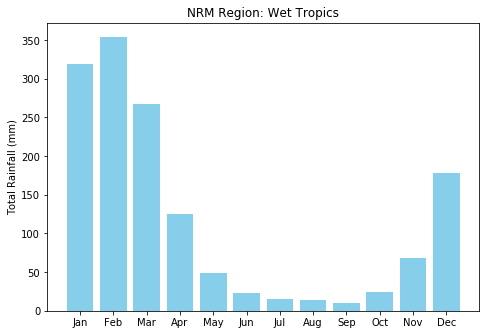

In [37]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
title = "NRM Region: %s"%(which_cluster)
ax.set_title(title) 
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_ylabel('Total Rainfall (mm)')
xx = ax.bar(months, df_m['Wet Tropics'], color = 'skyblue')
ax.text(x = months, y = df_m['Wet Tropics'],label = df_m['Wet Tropics'], va='center', ha='right',cex = 0.8, col = 'k')
output_file = 'Rainfall_climatology_%s.jpeg'%(which_cluster)
plt.savefig(os.path.join('/g/data/er4/zk6340/Hydro_projection',output_file))
plt.show()

In [34]:
df_m.index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [12]:
# ## Customer folder path
# ## customer_dir = DataRequest_dir + 'AWAP/MDB/'
# customer_dir = DataRequest_dir + 'AWRA-input/ISIMIP/historical/ACCESS1/VIC/'

In [13]:
# # save daily data in mm
# for v in ddf:
#     print('writing data for', v)
#     ddf[v].to_csv(customer_dir +  v + '_ACCESS1daily2.csv')

In [14]:
# # save monthly data in mm
# for v in ddf:
#     print('working on', v)
#     ddf[v].resample('MS').sum().to_csv(customer_dir + v + '_ACCESS1monthly2.csv')
# # for v in ddf: #for MDB farm dam data
# #     print('working on', v)
# #     ddf[v].resample('MS', how='sum').transpose().sort().transpose().to_csv(customer_dir + '/' + v + '_monthly_mm.csv')

In [15]:
# # ## save annual data in mm
# for v in ddf:
#     ddf[v].resample(rule='A-DEC').sum().to_csv(customer_dir + v + '_ACCESS1annual2.csv')`